In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
from src.data.some_dataloader import RedditDataset
from src.utils.data_utils import get_df_time_window
from src.utils.plot_utils import plot_subreddit_graph
from src.utils.data_utils import compute_core_subgraph

In [2]:
dataset = RedditDataset()
data = dataset.data

Top 10 subreddits by graph core density:
['askreddit', 'todayilearned', 'creepy', 'writingprompts', 'iama', 'pics', 'documentaries', 'newsokur', 'movies', 'leagueoflegends']
Nodes: 10, Edges: 60


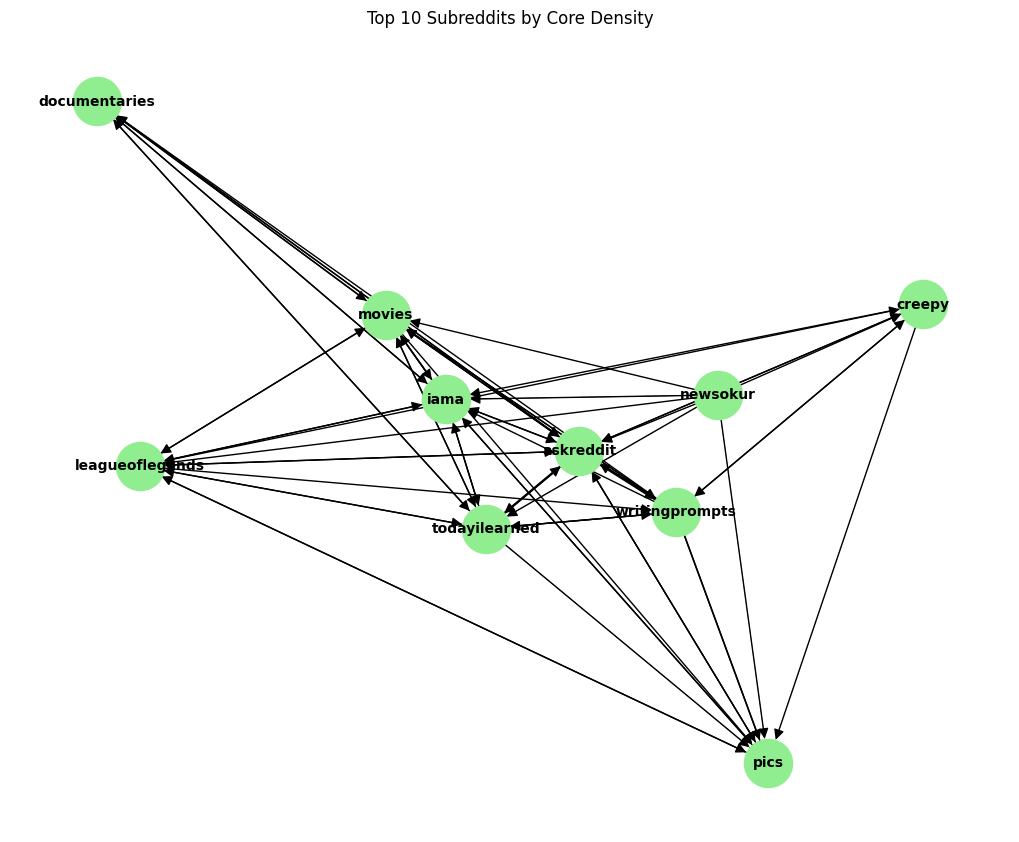

In [3]:
n_core = 10
G_core = compute_core_subgraph(data, k=n_core)
plot_subreddit_graph(G_core, title=f"Top {n_core} Subreddits by Core Density")

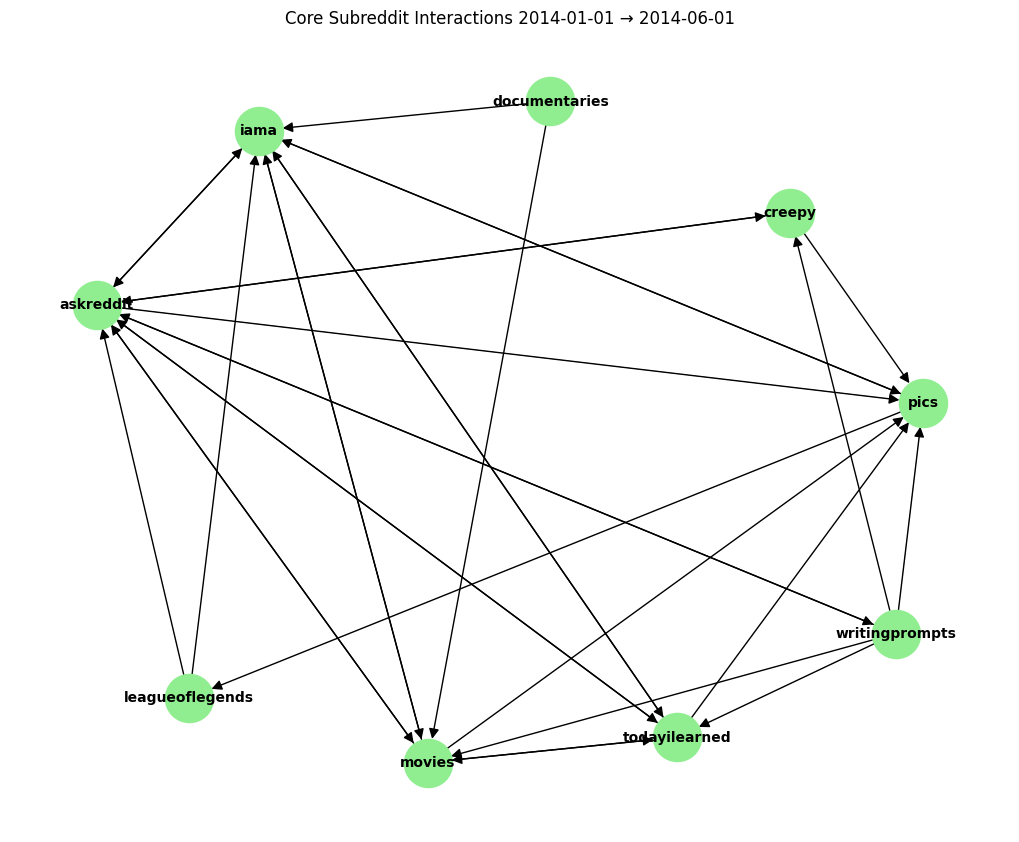

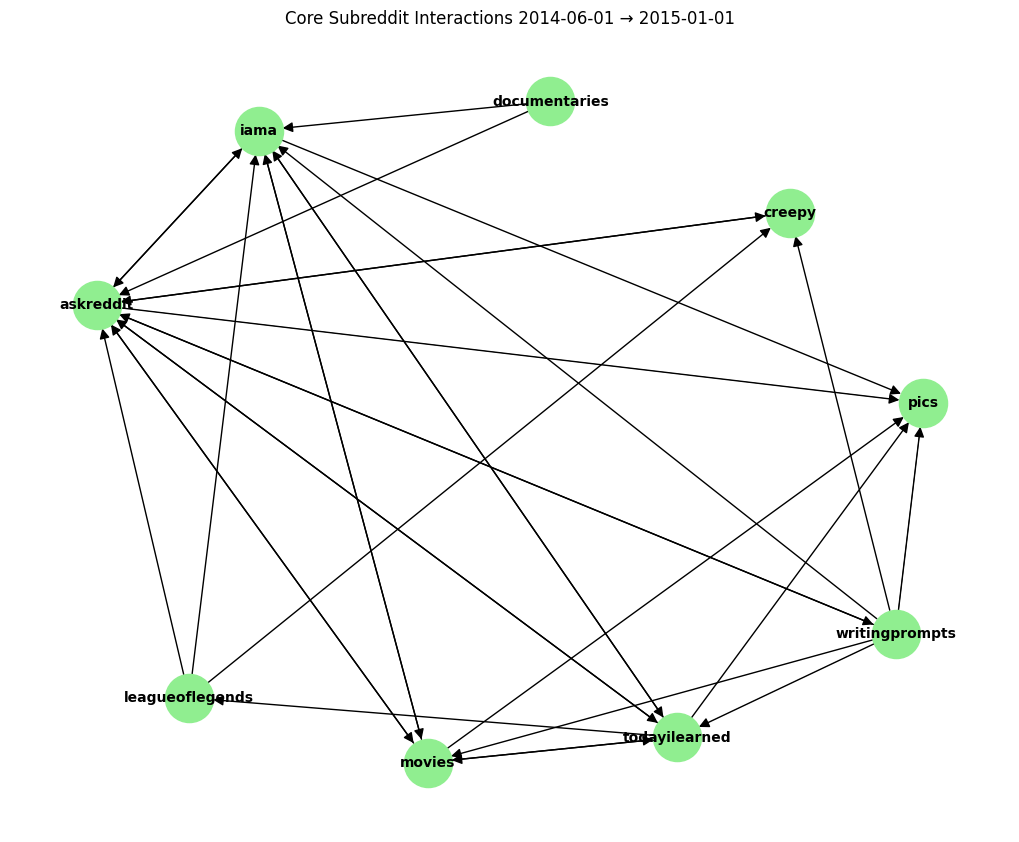

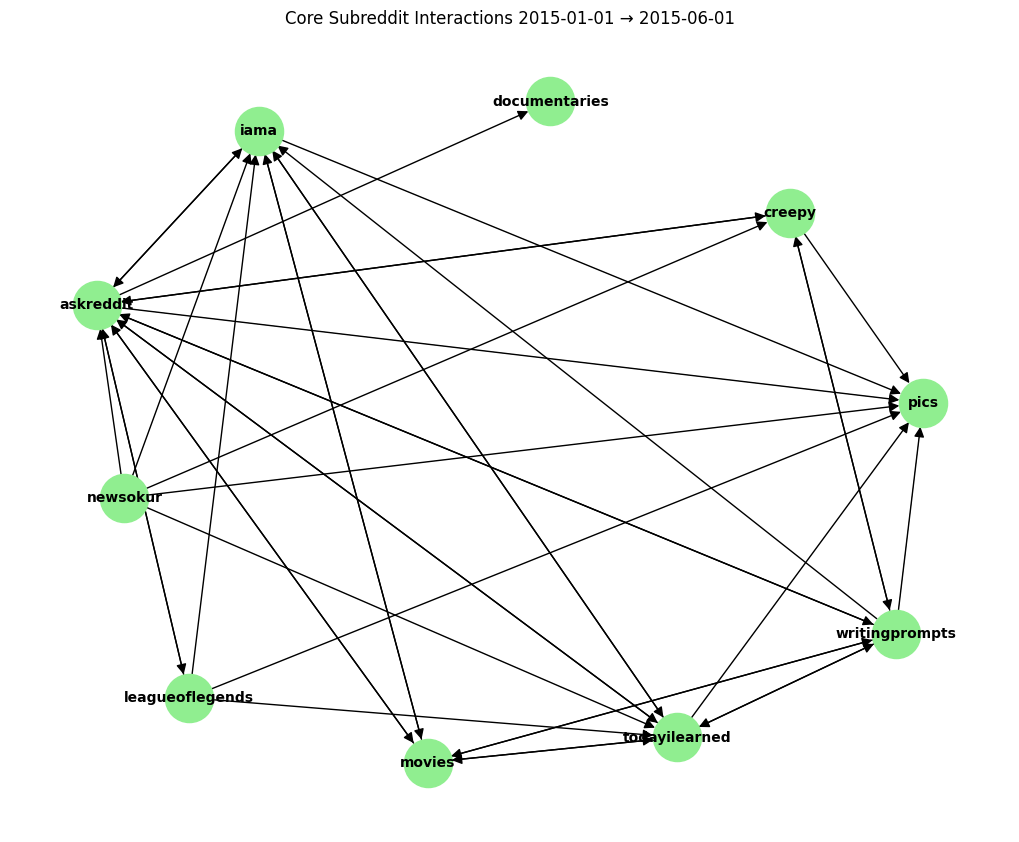

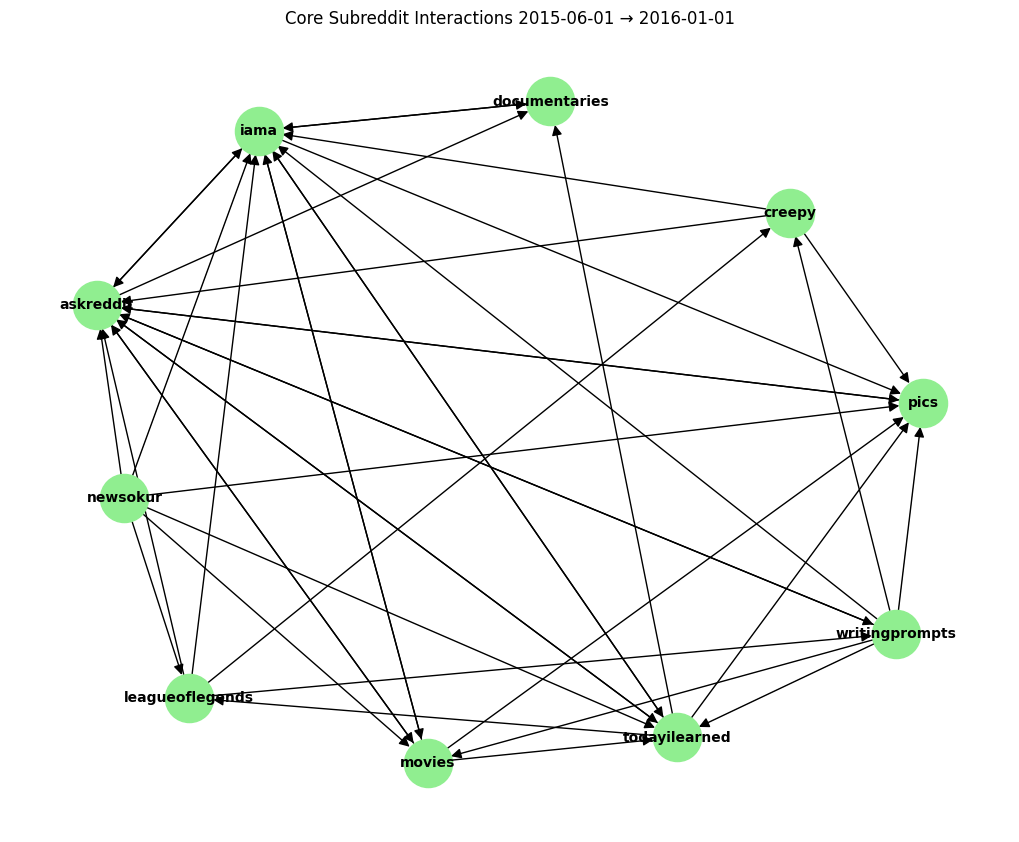

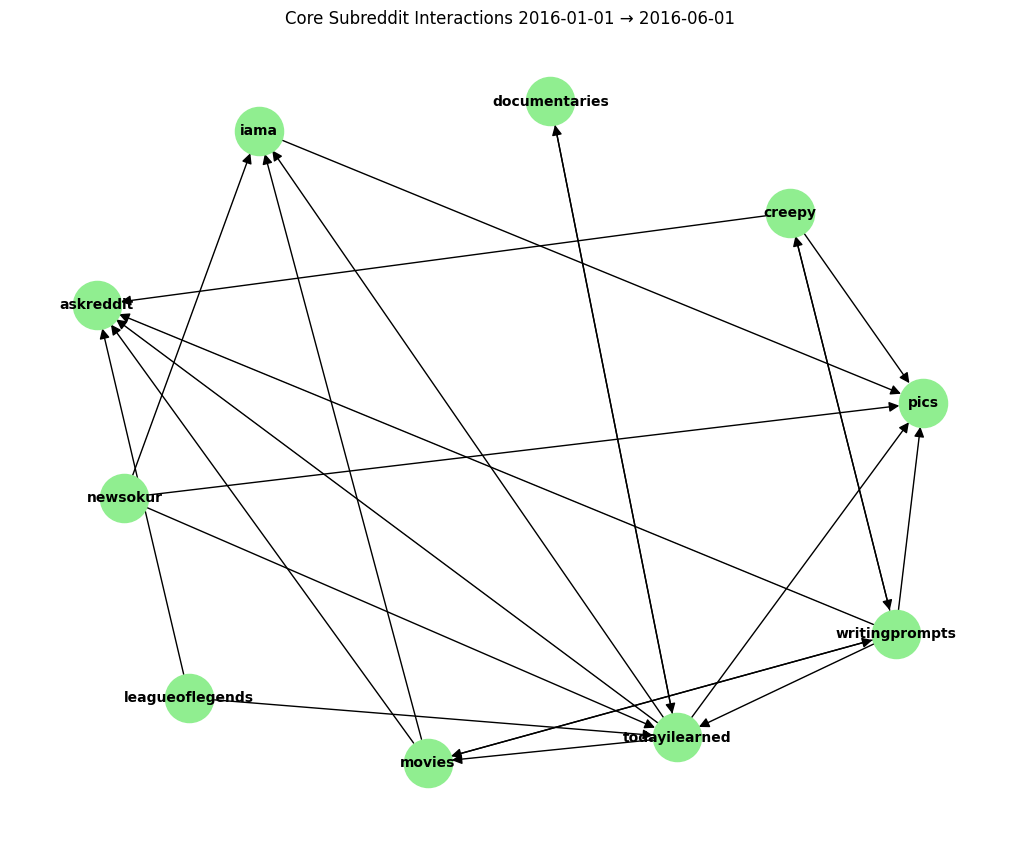

In [5]:
# === Plot interactions between core subreddits across multiple time windows ===

# Get the subreddits in the global core
core_subreddits = list(G_core.nodes())

# Define time windows
time_windows = [
    ("2014-01-01", "2014-06-01"),
    ("2014-06-01", "2015-01-01"),
    ("2015-01-01", "2015-06-01"),
    ("2015-06-01", "2016-01-01"),
    ("2016-01-01", "2016-06-01"),
]

# === Compute fixed node positions ===
# Build a "master" graph containing all core subreddits (no edges needed)
G_master = nx.DiGraph()
G_master.add_nodes_from(core_subreddits)
# Compute layout once and reuse
pos = nx.spring_layout(G_master, k=0.5, seed=42)

# === Plot each timeframe ===
for start, end in time_windows:
    # Filter data to core subreddits only
    df_core = data[
        data["SOURCE_SUBREDDIT"].isin(core_subreddits) &
        data["TARGET_SUBREDDIT"].isin(core_subreddits)
    ]

    # Crop to current time window
    df_window = get_df_time_window(df_core, start, end)

    # Build edges for this time window
    edges = (
        df_window.groupby(["SOURCE_SUBREDDIT", "TARGET_SUBREDDIT"])
        .size()
        .reset_index(name="weight")
    )

    # Build directed weighted graph for this window
    G_window = nx.from_pandas_edgelist(
        edges,
        "SOURCE_SUBREDDIT",
        "TARGET_SUBREDDIT",
        ["weight"],
        create_using=nx.DiGraph()
    )

    # Plot using the fixed positions
    plot_subreddit_graph(G_window, f"Core Subreddit Interactions {start} → {end}", pos=pos)


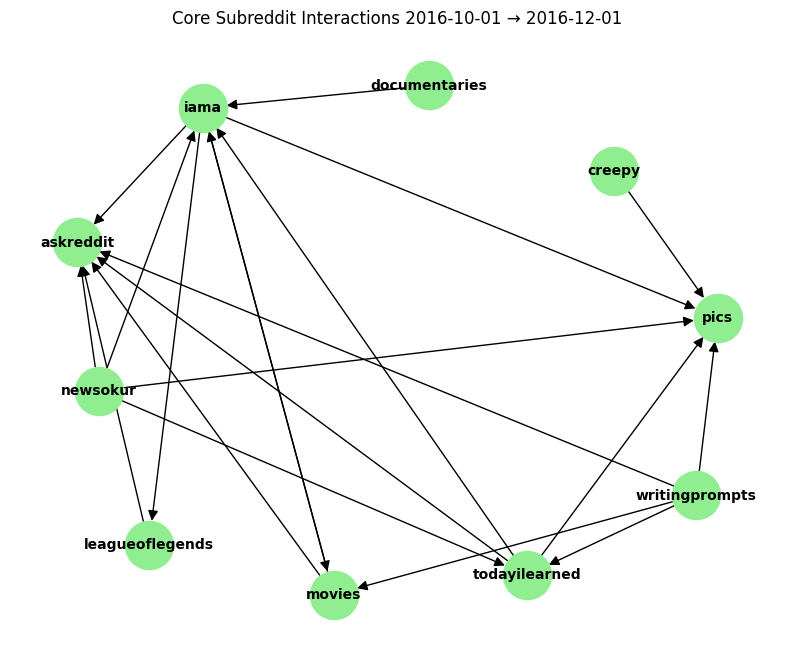

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation
from src.data.plot_utils import *
# === Prepare your graphs ===
'''time_windows = [
    ("2014-01-01", "2014-04-01"),
    ("2014-04-01", "2014-07-01"),
    ("2014-07-01", "2014-10-01"),
    ("2014-10-01", "2014-12-01"),
    ("2015-01-01", "2015-04-01"),
    ("2015-04-01", "2015-07-01"),
    ("2015-07-01", "2015-10-01"),
    ("2015-10-01", "2015-12-01"),
    ("2016-01-01", "2016-04-01"),
    ("2016-04-01", "2016-07-01"),
    ("2016-07-01", "2016-10-01"),
    ("2016-10-01", "2016-12-01"),
]'''

("2014-01-01", "2014-04-01"),
("2014-04-01", "2014-07-01"),
("2014-07-01", "2014-10-01"),
("2014-10-01", "2014-12-01"),
("2015-01-01", "2015-04-01"),
("2015-04-01", "2015-07-01"),
("2015-07-01", "2015-10-01"),
("2015-10-01", "2015-12-01"),
("2016-01-01", "2016-04-01"),
("2016-04-01", "2016-07-01"),
("2016-07-01", "2016-10-01"),
("2016-10-01", "2016-12-01"),

# Compute fixed layout
core_subreddits = list(G_core.nodes())
G_master = nx.DiGraph()
G_master.add_nodes_from(core_subreddits)
pos = nx.spring_layout(G_master, k=0.5, seed=42)

# Precompute graphs for each time window
graphs = []
labels = []
for start, end in time_windows:
    df_core = data[
        data["SOURCE_SUBREDDIT"].isin(core_subreddits) &
        data["TARGET_SUBREDDIT"].isin(core_subreddits)
    ]
    df_window = get_df_time_window(df_core, start, end)
    edges = (
        df_window.groupby(["SOURCE_SUBREDDIT", "TARGET_SUBREDDIT"])
        .size()
        .reset_index(name="weight")
    )
    G_window = nx.from_pandas_edgelist(
        edges,
        "SOURCE_SUBREDDIT",
        "TARGET_SUBREDDIT",
        ["weight"],
        create_using=nx.DiGraph()
    )
    graphs.append(G_window)
    labels.append(f"{start} → {end}")

# === Create animation ===
fig, ax = plt.subplots(figsize=(10, 8))

def update(frame):
    ax.clear()
    G = graphs[frame]
    nx.draw(
        G, pos,
        with_labels=True,
        node_size=1200,
        node_color="lightgreen",
        font_size=10,
        font_weight="bold",
        arrowsize=15,
        ax=ax
    )
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=[w / 100 for w in weights], ax=ax)
    ax.set_title(f"Core Subreddit Interactions {labels[frame]}")
    ax.axis("off")

ani = FuncAnimation(fig, update, frames=len(graphs), interval=400, repeat=True)

# Save as video or GIF
ani.save("subreddit_evolution.gif", writer="pillow", dpi=150)
# or:
# ani.save("subreddit_evolution.gif", writer="pillow", dpi=150)

plt.show()


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from src.utils.plot_utils import animate_subreddit_evolution

# Set the family : core subreddits (perhaps not a wise choice but ok for demo)
n_core = 10
G_core = compute_core_subgraph(data, k=n_core)
plot_subreddit_graph(G_core, title=f"Top {n_core} Subreddits by Core Density")

# Build week-by-week graphs for one year
year = 2015

# Create weekly windows
weekly_windows = pd.date_range(f"{year}-01-01", f"{year}-12-31", freq="W")

core_subreddits = list(G_core.nodes())

# Compute fixed positions once
G_master = nx.DiGraph()
G_master.add_nodes_from(core_subreddits)
pos = nx.spring_layout(G_master, k=0.5, seed=42)

graphs = []
labels = []

for i in range(len(weekly_windows) - 1):
    start = weekly_windows[i].strftime("%Y-%m-%d")
    end = weekly_windows[i + 1].strftime("%Y-%m-%d")

    df_core = data[
        data["SOURCE_SUBREDDIT"].isin(core_subreddits)
        & data["TARGET_SUBREDDIT"].isin(core_subreddits)
    ]

    df_window = get_df_time_window(df_core, start, end)

    edges = (
        df_window.groupby(["SOURCE_SUBREDDIT", "TARGET_SUBREDDIT"])
        .size()
        .reset_index(name="weight")
    )

    G_week = nx.from_pandas_edgelist(
        edges,
        "SOURCE_SUBREDDIT",
        "TARGET_SUBREDDIT",
        ["weight"],
        create_using=nx.DiGraph()
    )

    graphs.append(G_week)
    labels.append(f"Week of {start}")

# === Animate the year week-by-week ===
animate_subreddit_evolution(graphs, labels, pos, save_path=f"subreddit_{year}_weekly.gif", interval=400)


ImportError: cannot import name 'animate_subreddit_evolution' from 'src.utils.plot_utils' (c:\Users\Matteo\Documents\GitHub\ada-2025-project-othertagada\src\utils\plot_utils.py)